# Project 3: Web APIs & Classification

## Notebook 3: Preprocessing and Modeling

### Contents:
- [Word Cloud](#Word-Cloud)
- [Tokenizing combine text](#Tokenizing-combine-text)
- [Stem tokens](#Stem-tokens)
- [Lemmatized tokens](#Lemmatized-tokens)
- [Train-Test Split](#Train-Test-Split)
- [GridSearchCV](#GridSearchCV)
    - [CountVectorizer](#CountVectorizer)  
        - [Without stem or lemmatize](#Without-stem-or-lemmatize)
        - [Stem](#Stem)
        - [Lemmatized](#Lemmatized)
    - [TF-IDF](#TF-IDF)
        - [Without stem or lemmatize (TF)](#Without-stem-or-lemmatize-(TF))
        - [Stem (TF)](#Stem-(TF))
        - [Lemmatized (TF)](#Lemmatized-(TF))
- [Model assessment](#Model-assessment)
    - [Baseline score](#Baseline-score)
- [Model selections:](#Model-selections:)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score 

# word cloud library
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# library to preprocess XML characters entity reference back
from xml.sax.saxutils import unescape

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Word Cloud

In [2]:
df = pd.read_csv('../datasets/df_eda.csv')

In [3]:
df.shape

(1997, 7)

In [4]:
df.head()

,post_id,title,post_text,upvotes,downvotes,is_dems,combine_text
0,t3_7gzh5a,This is President Barack Obama. He did not sel...,NaN,54436,0,0,This is President Barack Obama. He did not sel...
1,t3_7ekych,Join The Battle For Net Neutrality! Don't Let ...,NaN,30254,0,0,Join The Battle For Net Neutrality! Don't Let ...
2,t3_7oj9cv,Republican ‘pro-life’ congressman slept with p...,NaN,19729,0,0,Republican ‘pro-life’ congressman slept with p...
3,t3_85y5ja,It would not be polite to ask the President to...,NaN,19068,0,0,It would not be polite to ask the President to...
4,t3_89dmy7,"Brian Klaas: ""The President is openly attempti...",NaN,17387,0,0,"Brian Klaas: ""The President is openly attempti..."


In [5]:
# converting any XML character back
df['combine_text'] = df['combine_text'].apply(unescape)

In [6]:
# remove \n from texts
df.combine_text[1400]

"I honestly think if you are conservative or republican you should leave Reddit behind.  I'm tired of supporting a website that not only allows but encourages manipulation. this entire platform has become a propaganda tool. Being misrepresented and lied about everyday of the week it's very hard to keep from becoming bitter and angry it's just not good for you.\n\n\nWe were here before the astroturfing when things used to be equal. since then we have become 2nd class citizens on this website. \n\n\nI think we are only giving credibility by being on this website to the things they say and I don't think that's a good idea."

In [8]:
for i, text in enumerate(df['combine_text']):
    df['combine_text'].loc[i] = text.replace('\n', '').strip()

In [9]:
df.combine_text[1400]

"I honestly think if you are conservative or republican you should leave Reddit behind.  I'm tired of supporting a website that not only allows but encourages manipulation. this entire platform has become a propaganda tool. Being misrepresented and lied about everyday of the week it's very hard to keep from becoming bitter and angry it's just not good for you.We were here before the astroturfing when things used to be equal. since then we have become 2nd class citizens on this website. I think we are only giving credibility by being on this website to the things they say and I don't think that's a good idea."

In [10]:
def draw_wordcloud_rep(text, plot_title = None, mask_img = None):
    mask = np.array(Image.open(mask_img))

    wordcloud = WordCloud(mask = mask,
                          scale = 7,
                          max_words = 1000,
                          background_color = 'lightcoral',
                          colormap = 'gist_gray',
                          contour_width = 60,
                          contour_color = 'black',
                          stopwords = STOPWORDS,
                          random_state = 42).generate(text)
    
    plt.figure(figsize = (14, 14), facecolor = 'white')
    plt.imshow(wordcloud, interpolation = "bilinear")
    if plot_title:
        plt.title(plot_title, fontsize = 20, pad = 50)
    plt.axis("off")

In [11]:
def draw_wordcloud_dem(text, plot_title = None, mask_img = None):
    mask = np.array(Image.open(mask_img))

    wordcloud = WordCloud(mask = mask,
                          scale = 7,
                          max_words = 1000,
                          background_color = 'royalblue',
                          colormap = 'gist_gray',
                          contour_width = 60,
                          contour_color = 'black',
                          stopwords = STOPWORDS,
                          random_state = 42).generate(text)
    
    plt.figure(figsize = (14, 14), facecolor = 'white')
    plt.imshow(wordcloud, interpolation = "bilinear")
    if plot_title:
        plt.title(plot_title, fontsize = 20, pad = 50)
    plt.axis("off")

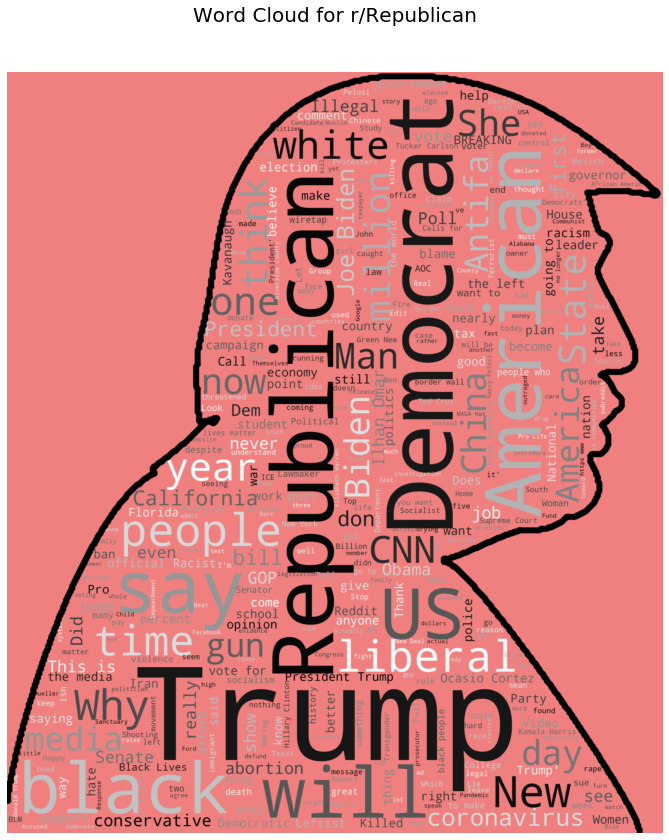

In [18]:
draw_wordcloud_rep(str(df[df['is_dems'] == 1].combine_text.ravel()),
                   plot_title = 'Word Cloud for r/Republican',
                   mask_img = '../images/reps_mask.png')

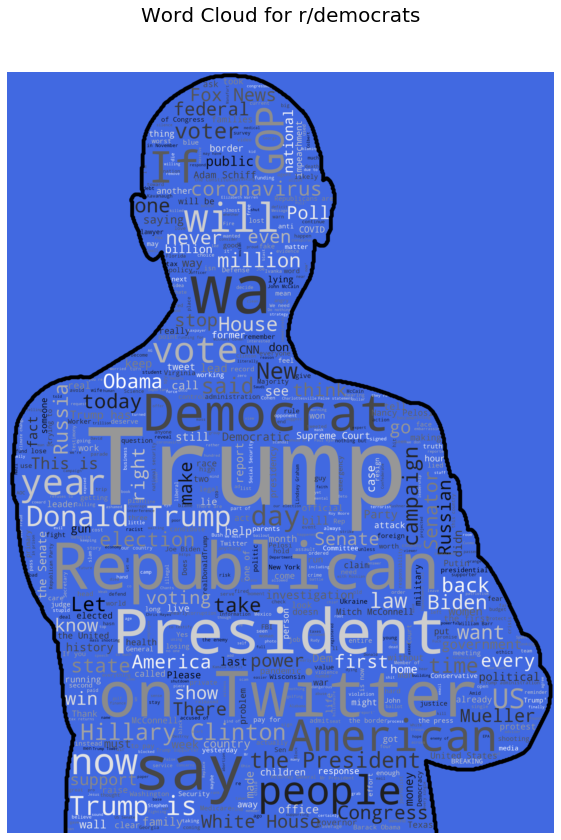

In [19]:
draw_wordcloud_dem(str(df[df['is_dems'] == 0].combine_text.ravel()),
                   plot_title = 'Word Cloud for r/democrats',
                   mask_img = '../images/dems_mask.png')

In [21]:
cv = CountVectorizer(stop_words = 'english')
tf = TfidfVectorizer(stop_words = 'english')

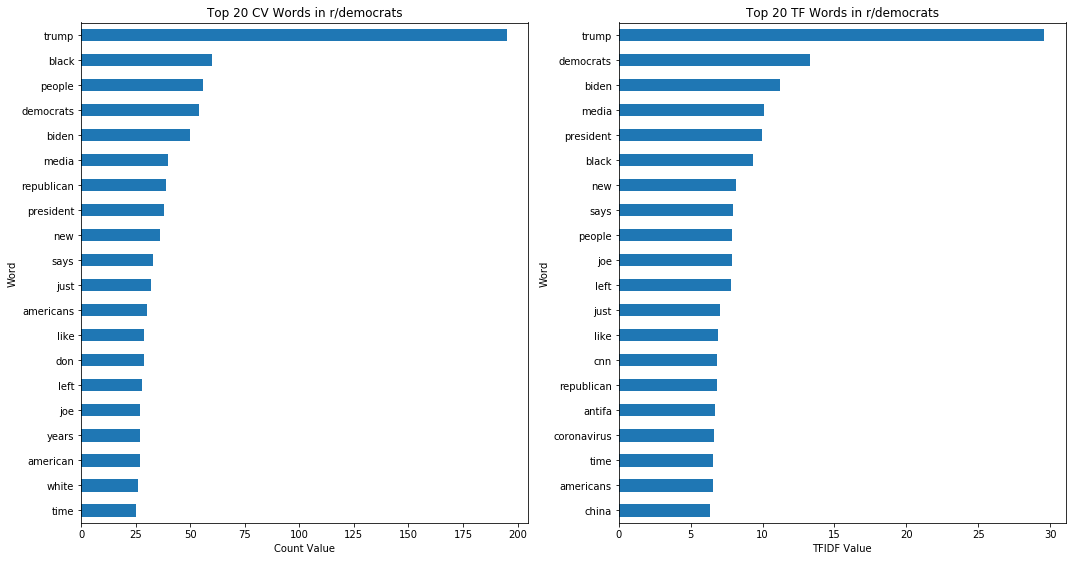

In [37]:
# Explore CountVectorizer token counts in r/democrats
word_cv_dems = pd.DataFrame(cv.fit_transform(df[df['is_dems'] == 1].combine_text).todense(),
                            columns = cv.get_feature_names())
word_cv_count_dems = word_cv_dems.sum(axis = 0)

# Explore TfidfVectorizer token counts in r/democrats
word_tf_dems = pd.DataFrame(tf.fit_transform(df[df['is_dems'] == 1].combine_text).todense(),
                            columns = tf.get_feature_names())
word_count_tf_dems = word_tf_dems.sum(axis=0)

# Plot top 20 words
plt.figure(figsize=(15, 15), facecolor='white')

plt.subplot(2,2,1)
word_cv_count_dems.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 CV Words in r/democrats')
plt.xlabel('Count Value')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_count_tf_dems.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TF Words in r/democrats')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

For the democrats subreddit we can see that the top few words that are standing out between the different vectorizer is trump, democrats, biden, media, black.

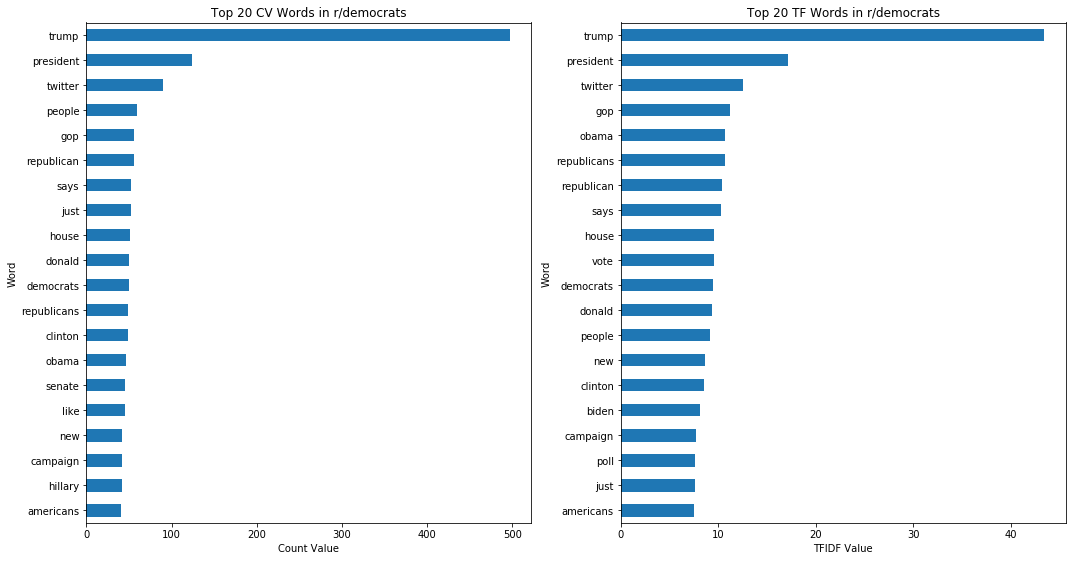

In [36]:
# Explore CountVectorizer token counts in r/Republican
word_cv_dems = pd.DataFrame(cv.fit_transform(df[df['is_dems'] == 0].combine_text).todense(),
                            columns = cv.get_feature_names())
word_cv_count_dems = word_cv_dems.sum(axis = 0)

# Explore TfidfVectorizer token counts in r/Republican
word_tf_dems = pd.DataFrame(tf.fit_transform(df[df['is_dems'] == 0].combine_text).todense(),
                            columns = tf.get_feature_names())
word_count_tf_dems = word_tf_dems.sum(axis=0)

# Plot top 20 words
plt.figure(figsize=(15, 15), facecolor='white')

plt.subplot(2,2,1)
word_cv_count_dems.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 CV Words in r/democrats')
plt.xlabel('Count Value')
plt.ylabel('Word')

plt.subplot(2,2,2)
word_count_tf_dems.sort_values().tail(20).plot(kind='barh')
plt.title('Top 20 TF Words in r/democrats')
plt.xlabel('TFIDF Value')
plt.ylabel('Word')

plt.tight_layout()

For the republican subreddit we can see that the top few words that are standing out between the different vectorizer is trump, president, twitter, gop, republican.

### Tokenizing combine text

In [38]:
rt = RegexpTokenizer(r"[\w\'\-\%]+")

In [39]:
df.combine_text[0]

'This is President Barack Obama. He did not sell Americans out to the telecom lobby, but instead called upon on the FCC to take up the strongest possible rules to protect net neutrality, which they did at his instruction in 2015.'

In [41]:
combine_text_tokens = []

for i in range(len(df['combine_text'])):
    loop_tokens = rt.tokenize(df['combine_text'].iloc[i].lower())
    for j, token in enumerate(loop_tokens):
        
        # we are removing 1st, 2nd, 3rd etc
        if re.match(r"\d+[\w]*", token):
            loop_tokens[j] = ''
            
        # we are removing any additional \words from urls if there are
        if re.match(r"\\[\w]", token):
            loop_tokens[j] = ''
            
        # we are removing the subreddit name and http if 
        if ('democrats' in token) | ('republican' in token) | ('republicans' in token) | ('democrat' in token) | ('http' in token) | ('https' in token) :
            loop_tokens[j] = ''
    combine_text_tokens.append(loop_tokens)

In [42]:
len(combine_text_tokens)

1997

In [43]:
len(combine_text_tokens[0])

41

In [44]:
combine_text_tokens[0][:10]

['this',
 'is',
 'president',
 'barack',
 'obama',
 'he',
 'did',
 'not',
 'sell',
 'americans']

In [45]:
combine_text_tokens_list = []

for post in combine_text_tokens:
    combine_text_tokens_list.append(' '.join(post))

In [46]:
combine_text_tokens_list[:10]

['this is president barack obama he did not sell americans out to the telecom lobby but instead called upon on the fcc to take up the strongest possible rules to protect net neutrality which they did at his instruction in ',
 "join the battle for net neutrality don't let the fcc destroy the internet",
 ' pro-life congressman slept with patients and paid for their abortions god has forgiven me',
 'it would not be polite to ask the president to walk farther than  feet without a golf cart',
 'brian klaas the president is openly attempting to go after the owner of a private business because that person also owns a newspaper that accurately reports unflattering stories about the white house this is literally what erdogan putin did  in congress are enabling this too',
 "man who fueled trump's voter fraud conspiracy is registered in  states",
 'he will stop at nothing',
 'what a real president looks like',
 'tell them mr president',
 'house dems vs house gop diversity on display']

### Stem tokens

In [47]:
ps = PorterStemmer()

In [48]:
combine_text_tokens_stem = []

for post in combine_text_tokens:
    
    # empty post stem
    stem = []
    
    for word in post:
        
        # get stem of individual word
        word_stem = ps.stem(word)
        
        # add the stem word to post list
        stem.append(word_stem)
    
    # add post list into a single list
    combine_text_tokens_stem.append(stem)

In [49]:
combine_text_tokens_stem[0][:10]

['thi',
 'is',
 'presid',
 'barack',
 'obama',
 'he',
 'did',
 'not',
 'sell',
 'american']

The stem list is currently a list of list so we will have to reformat it to a single list of string for vectorizer.

In [50]:
combine_text_tokens_stem_list = []

for post in combine_text_tokens_stem:
    combine_text_tokens_stem_list.append(' '.join(post))

In [51]:
combine_text_tokens_stem_list[:10]

['thi is presid barack obama he did not sell american out to the telecom lobbi but instead call upon on the fcc to take up the strongest possibl rule to protect net neutral which they did at hi instruct in ',
 "join the battl for net neutral don't let the fcc destroy the internet",
 ' pro-lif congressman slept with patient and paid for their abort god ha forgiven me',
 'it would not be polit to ask the presid to walk farther than  feet without a golf cart',
 'brian klaa the presid is openli attempt to go after the owner of a privat busi becaus that person also own a newspap that accur report unflatt stori about the white hous thi is liter what erdogan putin did  in congress are enabl thi too',
 "man who fuel trump' voter fraud conspiraci is regist in  state",
 'he will stop at noth',
 'what a real presid look like',
 'tell them mr presid',
 'hous dem vs hous gop divers on display']

### Lemmatized tokens

In [52]:
lm = WordNetLemmatizer()

In [53]:
combine_text_tokens_lemma = []

for post in combine_text_tokens:
    
    # empty post lemmatized 
    lemma = []
    
    for word in post:
        
        # get lemmatized word
        word_lemma = lm.lemmatize(word)
        
        # add the lemmatized word to post list
        lemma.append(word_lemma)
    
    # add post list into a single list
    combine_text_tokens_lemma.append(lemma)

In [54]:
combine_text_tokens_lemma[0][:10]

['this',
 'is',
 'president',
 'barack',
 'obama',
 'he',
 'did',
 'not',
 'sell',
 'american']

The lemmatized list is currently a list of list so we will have to reformat it to a single list of string for vectorizer.

In [55]:
combine_text_tokens_lemma_list = []

for post in combine_text_tokens_lemma:
    combine_text_tokens_lemma_list.append(' '.join(post))

In [56]:
combine_text_tokens_lemma_list[:10]

['this is president barack obama he did not sell american out to the telecom lobby but instead called upon on the fcc to take up the strongest possible rule to protect net neutrality which they did at his instruction in ',
 "join the battle for net neutrality don't let the fcc destroy the internet",
 ' pro-life congressman slept with patient and paid for their abortion god ha forgiven me',
 'it would not be polite to ask the president to walk farther than  foot without a golf cart',
 'brian klaas the president is openly attempting to go after the owner of a private business because that person also owns a newspaper that accurately report unflattering story about the white house this is literally what erdogan putin did  in congress are enabling this too',
 "man who fueled trump's voter fraud conspiracy is registered in  state",
 'he will stop at nothing',
 'what a real president look like',
 'tell them mr president',
 'house dems v house gop diversity on display']

In [57]:
df_processed = pd.DataFrame(data = [combine_text_tokens_list, combine_text_tokens_stem_list, combine_text_tokens_lemma_list],
                            index = ['combine_text_tokens', 'combine_text_stem', 'combine_text_lemma']).T

In [58]:
df_processed['is_dems'] = df['is_dems']

In [59]:
df_processed

,combine_text_tokens,combine_text_stem,combine_text_lemma,is_dems
0,this is president barack obama he did not sell...,thi is presid barack obama he did not sell ame...,this is president barack obama he did not sell...,0
1,join the battle for net neutrality don't let t...,join the battl for net neutral don't let the f...,join the battle for net neutrality don't let t...,0
2,pro-life congressman slept with patients and ...,pro-lif congressman slept with patient and pa...,pro-life congressman slept with patient and p...,0
3,it would not be polite to ask the president to...,it would not be polit to ask the presid to wal...,it would not be polite to ask the president to...,0
4,brian klaas the president is openly attempting...,brian klaa the presid is openli attempt to go ...,brian klaas the president is openly attempting...,0
...,...,...,...,...
1992,ny times newest editorial board member doesn't...,ny time newest editori board member doesn't se...,ny time newest editorial board member doesn't ...,1
1993,why on earth should anyone believe china s cor...,whi on earth should anyon believ china s coron...,why on earth should anyone believe china s cor...,1
1994,california court strikes down law seeking rele...,california court strike down law seek releas o...,california court strike down law seeking relea...,1
1995,tom fitton to testify on clinton foundation,tom fitton to testifi on clinton foundat,tom fitton to testify on clinton foundation,1


In [39]:
df_processed.to_csv('../datasets/df_processed.csv', index = False)

### Train-Test Split

In [60]:
X = df_processed[['combine_text_tokens', 'combine_text_stem', 'combine_text_lemma']]
y = df_processed['is_dems']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [62]:
X_train

,combine_text_tokens,combine_text_stem,combine_text_lemma
615,the guy is a walking sugar cookie,the guy is a walk sugar cooki,the guy is a walking sugar cookie
526,claire mccaskill on twitter when agents were ...,clair mccaskil on twitter when agent were mak...,claire mccaskill on twitter when agent were m...
1715,southfield city clerk charged with felonies t...,southfield citi clerk charg with feloni tie t...,southfield city clerk charged with felony tie...
715,amy siskind on the eve of the second mass shoo...,ami siskind on the eve of the second mass shoo...,amy siskind on the eve of the second mass shoo...
1806,hmmm and they call fascist,hmmm and they call fascist,hmmm and they call fascist
...,...,...,...
1139,you know it,you know it,you know it
253,president trump impeached for abuse of power o...,presid trump impeach for abus of power obstruc...,president trump impeached for abuse of power o...
1037,history,histori,history
1065,just imagine,just imagin,just imagine


In [63]:
X_test

,combine_text_tokens,combine_text_stem,combine_text_lemma
1368,public banned from seeing school shooting case...,public ban from see school shoot case involv t...,public banned from seeing school shooting case...
654,guests at trump national golf club disco party...,guest at trump nation golf club disco parti ge...,guest at trump national golf club disco party ...
1776,coronavirus response shows trump isn t a dictator,coronaviru respons show trump isn t a dictat,coronavirus response show trump isn t a dictator
646,trump's trail of tears joke isn't his first ab...,trump' trail of tear joke isn't hi first about...,trump's trail of tear joke isn't his first abo...
1169,what could go wrong,what could go wrong,what could go wrong
...,...,...,...
1318,the u s will finally designate the muslim brot...,the u s will final design the muslim brotherho...,the u s will finally designate the muslim brot...
1634,andrew gillum has conceded defeat after a reco...,andrew gillum ha conced defeat after a recount...,andrew gillum ha conceded defeat after a recou...
232,fox news had stormy daniels story before elec...,fox news had stormi daniel stori befor elect ...,fox news had stormy daniel story before elect...
1294,pro-trump miss michigan who refused to try on ...,pro-trump miss michigan who refus to tri on hi...,pro-trump miss michigan who refused to try on ...


In [64]:
y_train = pd.DataFrame(y_train, columns = ['is_dems'])
y_test = pd.DataFrame(y_test, columns = ['is_dems'])

In [65]:
X_train.to_csv('../datasets/X_train.csv', index = True)
X_test.to_csv('../datasets/X_test.csv', index = True)
y_train.to_csv('../datasets/y_train.csv', index = True)
y_test.to_csv('../datasets/y_test.csv', index = True)

In [2]:
X_train = pd.read_csv('../datasets/X_train.csv')
X_test = pd.read_csv('../datasets/X_test.csv')
# y_train.to_csv('../datasets/y_train.csv')
# y_test.to_csv('../datasets/y_test.csv')

In [3]:
print(X_train.shape, X_test.shape)

(1497, 4) (500, 4)


In [4]:
X_train.columns

Index(['Unnamed: 0', 'combine_text_tokens', 'combine_text_stem',
       'combine_text_lemma'],
      dtype='object')

In [5]:
X_test.columns

Index(['Unnamed: 0', 'combine_text_tokens', 'combine_text_stem',
       'combine_text_lemma'],
      dtype='object')

## GridSearchCV

### CountVectorizer

In [66]:
gr_cv_list = [[('cv', CountVectorizer()), ('multi_nb', MultinomialNB())],
              [('cv', CountVectorizer()), ('scaler', StandardScaler(with_mean = False)), ('logreg', LogisticRegression())],
              [('cv', CountVectorizer()), ('rf', RandomForestClassifier())]]

In [67]:
titles = ['multi_nb', 'logreg', 'rf']

In [68]:
pipe_params_cv = [{"cv__stop_words": ['english'], "cv__ngram_range": [(1, 1), (1, 2)]},
                  {"cv__stop_words": ['english'], "cv__ngram_range": [(1, 1), (1, 2)]},
                  {"cv__stop_words": ['english'], "cv__ngram_range": [(1, 1), (1, 2)]}]

In [69]:
grid_results = pd.DataFrame(columns = ['model', 'test_data', 'best_params', 'train_accuracy', 'test_accuracy', 'tn', 'fp', 'fn', 'tp'])

#### Without stem or lemmatize

In [70]:
X_train_none = X_train['combine_text_tokens']
X_test_none = X_test['combine_text_tokens']

In [71]:
for i in range(len(gr_cv_list)):           
    pipe = Pipeline(steps = gr_cv_list[i])               # configure pipeline for each model
    grid = GridSearchCV(pipe, pipe_params_cv[i], cv = 3) # fit GridSearchCV to model and model's params

    model_results = {}

    grid.fit(X_train_none, y_train.values.ravel())
    
    print('Model: ', titles[i])
    model_results['model'] = titles[i]
    
    model_results['test_data'] = 'X_train_none'

    print('Best Params: ', grid.best_params_)
    model_results['best_params'] = grid.best_params_

    print('Training Accuracy: ', grid.score(X_train_none, y_train))
    model_results['train_accuracy'] = grid.score(X_train_none, y_train)
    
    print('Testing Accuracy: ', grid.score(X_test_none, y_test), '\n')
    model_results['test_accuracy'] = grid.score(X_test_none, y_test)

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, grid.predict(X_test_none)).ravel() 
    print("True Negatives: %s" % tn)
    model_results['tn'] = tn

    print("False Positives: %s" % fp)  
    model_results['fp'] = fp

    print("False Negatives: %s" % fn)
    model_results['fn'] = fn

    print("True Positives: %s" % tp, '\n')
    model_results['tp'] = tp
    
    print("Precision Score: ", precision_score(y_test, grid.predict(X_test_none)))
    model_results['precision'] = precision_score(y_test, grid.predict(X_test_none))
    
    print("Recall Score: ", recall_score(y_test, grid.predict(X_test_none)))
    model_results['recall'] = recall_score(y_test, grid.predict(X_test_none))
    
    print("F1 Score: ", f1_score(y_test, grid.predict(X_test_none)), '\n')
    model_results['f1'] = f1_score(y_test, grid.predict(X_test_none))
    
    grid_results = grid_results.append(model_results, ignore_index=True)

Model:  multi_nb
Best Params:  {'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}
Training Accuracy:  0.9799599198396793
Testing Accuracy:  0.744 

True Negatives: 206
False Positives: 44
False Negatives: 84
True Positives: 166 

Precision Score:  0.7904761904761904
Recall Score:  0.664
F1 Score:  0.7217391304347827 

Model:  logreg
Best Params:  {'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}
Training Accuracy:  0.9966599866399466
Testing Accuracy:  0.678 

True Negatives: 133
False Positives: 117
False Negatives: 44
True Positives: 206 

Precision Score:  0.6377708978328174
Recall Score:  0.824
F1 Score:  0.719022687609075 

Model:  rf
Best Params:  {'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}
Training Accuracy:  0.9966599866399466
Testing Accuracy:  0.744 

True Negatives: 186
False Positives: 64
False Negatives: 64
True Positives: 186 

Precision Score:  0.744
Recall Score:  0.744
F1 Score:  0.744 



#### Stem

In [73]:
X_train_stem = X_train['combine_text_stem']
X_test_stem = X_test['combine_text_stem']

In [74]:
for i in range(len(gr_cv_list)):           
    pipe = Pipeline(steps = gr_cv_list[i])               # configure pipeline for each model
    grid = GridSearchCV(pipe, pipe_params_cv[i], cv = 3) # fit GridSearchCV to model and model's params

    model_results = {}

    grid.fit(X_train_stem, y_train.values.ravel())
    
    print('Model: ', titles[i])
    model_results['model'] = titles[i]

    model_results['test_data'] = 'X_train_stem'
    
    print('Best Params: ', grid.best_params_)
    model_results['best_params'] = grid.best_params_

    print('Training Accuracy: ', grid.score(X_train_stem, y_train))
    model_results['train_accuracy'] = grid.score(X_train_stem, y_train)
    
    print('Testing Accuracy: ', grid.score(X_test_stem, y_test), '\n')
    model_results['test_accuracy'] = grid.score(X_test_stem, y_test)

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, grid.predict(X_test_stem)).ravel() 
    print("True Negatives: %s" % tn)
    model_results['tn'] = tn

    print("False Positives: %s" % fp)  
    model_results['fp'] = fp

    print("False Negatives: %s" % fn)
    model_results['fn'] = fn

    print("True Positives: %s" % tp, '\n')
    model_results['tp'] = tp
    
    print("Precision Score: ", precision_score(y_test, grid.predict(X_test_stem)))
    model_results['precision'] = precision_score(y_test, grid.predict(X_test_stem))
    
    print("Recall Score: ", recall_score(y_test, grid.predict(X_test_stem)))
    model_results['recall'] = recall_score(y_test, grid.predict(X_test_stem))
    
    print("F1 Score: ", f1_score(y_test, grid.predict(X_test_stem)), '\n')
    model_results['f1'] = f1_score(y_test, grid.predict(X_test_stem))

    grid_results = grid_results.append(model_results, ignore_index=True)

Model:  multi_nb
Best Params:  {'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}
Training Accuracy:  0.9712758851035405
Testing Accuracy:  0.72 

True Negatives: 210
False Positives: 40
False Negatives: 100
True Positives: 150 

Precision Score:  0.7894736842105263
Recall Score:  0.6
F1 Score:  0.6818181818181819 

Model:  logreg
Best Params:  {'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}
Training Accuracy:  0.9959919839679359
Testing Accuracy:  0.67 

True Negatives: 145
False Positives: 105
False Negatives: 60
True Positives: 190 

Precision Score:  0.6440677966101694
Recall Score:  0.76
F1 Score:  0.6972477064220184 

Model:  rf
Best Params:  {'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}
Training Accuracy:  0.9959919839679359
Testing Accuracy:  0.72 

True Negatives: 187
False Positives: 63
False Negatives: 77
True Positives: 173 

Precision Score:  0.7330508474576272
Recall Score:  0.692
F1 Score:  0.7119341563786008 



#### Lemmatized

In [75]:
X_train_lemma = X_train['combine_text_lemma']
X_test_lemma = X_test['combine_text_lemma']

In [76]:
for i in range(len(gr_cv_list)):           
    pipe = Pipeline(steps = gr_cv_list[i])               # configure pipeline for each model
    grid = GridSearchCV(pipe, pipe_params_cv[i], cv = 3) # fit GridSearchCV to model and model's params

    model_results = {}

    grid.fit(X_train_lemma, y_train.values.ravel())
    
    print('Model: ', titles[i])
    model_results['model'] = titles[i]
    
    model_results['test_data'] = 'X_train_lemma'

    print('Best Params: ', grid.best_params_)
    model_results['best_params'] = grid.best_params_

    print('Training Accuracy: ', grid.score(X_train_lemma, y_train))
    model_results['train_accuracy'] = grid.score(X_train_lemma, y_train)
    
    print('Testing Accuracy: ', grid.score(X_test_lemma, y_test), '\n')
    model_results['test_accuracy'] = grid.score(X_test_lemma, y_test)

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, grid.predict(X_test_lemma)).ravel() 
    print("True Negatives: %s" % tn)
    model_results['tn'] = tn

    print("False Positives: %s" % fp)  
    model_results['fp'] = fp

    print("False Negatives: %s" % fn)
    model_results['fn'] = fn

    print("True Positives: %s" % tp, '\n')
    model_results['tp'] = tp
    
    print("Precision Score: ", precision_score(y_test, grid.predict(X_test_lemma)))
    model_results['precision'] = precision_score(y_test, grid.predict(X_test_lemma))
    
    print("Recall Score: ", recall_score(y_test, grid.predict(X_test_lemma)))
    model_results['recall'] = recall_score(y_test, grid.predict(X_test_lemma))
    
    print("F1 Score: ", f1_score(y_test, grid.predict(X_test_lemma)), '\n')
    model_results['f1'] = f1_score(y_test, grid.predict(X_test_lemma))

    grid_results = grid_results.append(model_results, ignore_index=True)

Model:  multi_nb
Best Params:  {'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}
Training Accuracy:  0.9759519038076152
Testing Accuracy:  0.734 

True Negatives: 207
False Positives: 43
False Negatives: 90
True Positives: 160 

Precision Score:  0.7881773399014779
Recall Score:  0.64
F1 Score:  0.7064017660044151 

Model:  logreg
Best Params:  {'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}
Training Accuracy:  0.9959919839679359
Testing Accuracy:  0.672 

True Negatives: 137
False Positives: 113
False Negatives: 51
True Positives: 199 

Precision Score:  0.6378205128205128
Recall Score:  0.796
F1 Score:  0.7081850533807829 

Model:  rf
Best Params:  {'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}
Training Accuracy:  0.9959919839679359
Testing Accuracy:  0.726 

True Negatives: 163
False Positives: 87
False Negatives: 50
True Positives: 200 

Precision Score:  0.6968641114982579
Recall Score:  0.8
F1 Score:  0.7448789571694601 



In [77]:
grid_results_cv = grid_results

In [78]:
grid_results_cv.sort_values('test_accuracy', ascending = False)

,model,test_data,best_params,train_accuracy,test_accuracy,tn,fp,fn,tp,f1,precision,recall
0,multi_nb,X_train_none,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.979960,0.744,206,44,84,166,0.721739,0.790476,0.664
2,rf,X_train_none,"{'cv__ngram_range': (1, 1), 'cv__stop_words': ...",0.996660,0.744,186,64,64,186,0.744000,0.744000,0.744
6,multi_nb,X_train_lemma,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.975952,0.734,207,43,90,160,0.706402,0.788177,0.640
8,rf,X_train_lemma,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.995992,0.726,163,87,50,200,0.744879,0.696864,0.800
3,multi_nb,X_train_stem,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.971276,0.720,210,40,100,150,0.681818,0.789474,0.600
5,rf,X_train_stem,"{'cv__ngram_range': (1, 1), 'cv__stop_words': ...",0.995992,0.720,187,63,77,173,0.711934,0.733051,0.692
1,logreg,X_train_none,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.996660,0.678,133,117,44,206,0.719023,0.637771,0.824
7,logreg,X_train_lemma,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.995992,0.672,137,113,51,199,0.708185,0.637821,0.796
4,logreg,X_train_stem,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.995992,0.670,145,105,60,190,0.697248,0.644068,0.760


### TF-IDF

In [79]:
gr_tf_list = [[('tf', TfidfVectorizer()), ('multi_nb', MultinomialNB())],
              [('tf', TfidfVectorizer()), ('scaler', StandardScaler(with_mean = False)), ('logreg', LogisticRegression())],
              [('tf', TfidfVectorizer()), ('rf', RandomForestClassifier())]]

In [80]:
pipe_params_tf = [{"tf__stop_words": ['english'], "tf__ngram_range": [(1, 1), (1, 2)]},
                  {"tf__stop_words": ['english'], "tf__ngram_range": [(1, 1), (1, 2)]},
                  {"tf__stop_words": ['english'], "tf__ngram_range": [(1, 1), (1, 2)]}]

In [81]:
grid_results = pd.DataFrame(columns = ['model', 'test_data', 'best_params', 'train_accuracy', 'test_accuracy', 'tn',
                                       'fp', 'fn', 'tp'])

#### Without stem or lemmatize (TF)

In [82]:
for i in range(len(gr_tf_list)):           
    pipe = Pipeline(steps = gr_tf_list[i])               # configure pipeline for each model
    grid = GridSearchCV(pipe, pipe_params_tf[i], cv = 3) # fit GridSearchCV to model and model's params

    model_results = {}

    grid.fit(X_train_none, y_train.values.ravel())
    
    print('Model: ', titles[i])
    model_results['model'] = titles[i]
    
    model_results['test_data'] = 'X_train_none'

    print('Best Params: ', grid.best_params_)
    model_results['best_params'] = grid.best_params_

    print('Training Accuracy: ', grid.score(X_train_none, y_train))
    model_results['train_accuracy'] = grid.score(X_train_none, y_train)
    
    print('Testing Accuracy: ', grid.score(X_test_none, y_test), '\n')
    model_results['test_accuracy'] = grid.score(X_test_none, y_test)

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, grid.predict(X_test_none)).ravel() 
    print("True Negatives: %s" % tn)
    model_results['tn'] = tn

    print("False Positives: %s" % fp)  
    model_results['fp'] = fp

    print("False Negatives: %s" % fn)
    model_results['fn'] = fn

    print("True Positives: %s" % tp, '\n')
    model_results['tp'] = tp
    
    print("Precision Score: ", precision_score(y_test, grid.predict(X_test_none)))
    model_results['precision'] = precision_score(y_test, grid.predict(X_test_none))
    
    print("Recall Score: ", recall_score(y_test, grid.predict(X_test_none)))
    model_results['recall'] = recall_score(y_test, grid.predict(X_test_none))
    
    print("F1 Score: ", f1_score(y_test, grid.predict(X_test_none)), '\n')
    model_results['f1'] = f1_score(y_test, grid.predict(X_test_none))

    grid_results = grid_results.append(model_results, ignore_index=True)

Model:  multi_nb
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Training Accuracy:  0.9926519706078825
Testing Accuracy:  0.742 

True Negatives: 202
False Positives: 48
False Negatives: 81
True Positives: 169 

Precision Score:  0.7788018433179723
Recall Score:  0.676
F1 Score:  0.7237687366167024 

Model:  logreg
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Training Accuracy:  0.9966599866399466
Testing Accuracy:  0.714 

True Negatives: 171
False Positives: 79
False Negatives: 64
True Positives: 186 

Precision Score:  0.7018867924528301
Recall Score:  0.744
F1 Score:  0.7223300970873786 

Model:  rf
Best Params:  {'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
Training Accuracy:  0.9966599866399466
Testing Accuracy:  0.758 

True Negatives: 188
False Positives: 62
False Negatives: 59
True Positives: 191 

Precision Score:  0.7549407114624506
Recall Score:  0.764
F1 Score:  0.7594433399602386 



#### Stem (TF)

In [83]:
for i in range(len(gr_tf_list)):           
    pipe = Pipeline(steps = gr_tf_list[i])               # configure pipeline for each model
    grid = GridSearchCV(pipe, pipe_params_tf[i], cv = 3) # fit GridSearchCV to model and model's params

    model_results = {}

    grid.fit(X_train_stem, y_train.values.ravel())
    
    print('Model: ', titles[i])
    model_results['model'] = titles[i]

    model_results['test_data'] = 'X_train_stem'
    
    print('Best Params: ', grid.best_params_)
    model_results['best_params'] = grid.best_params_

    print('Training Accuracy: ', grid.score(X_train_stem, y_train))
    model_results['train_accuracy'] = grid.score(X_train_stem, y_train)
    
    print('Testing Accuracy: ', grid.score(X_test_stem, y_test), '\n')
    model_results['test_accuracy'] = grid.score(X_test_stem, y_test)

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, grid.predict(X_test_stem)).ravel() 
    print("True Negatives: %s" % tn)
    model_results['tn'] = tn

    print("False Positives: %s" % fp)  
    model_results['fp'] = fp

    print("False Negatives: %s" % fn)
    model_results['fn'] = fn

    print("True Positives: %s" % tp, '\n')
    model_results['tp'] = tp
    
    print("Precision Score: ", precision_score(y_test, grid.predict(X_test_stem)))
    model_results['precision'] = precision_score(y_test, grid.predict(X_test_stem))
    
    print("Recall Score: ", recall_score(y_test, grid.predict(X_test_stem)))
    model_results['recall'] = recall_score(y_test, grid.predict(X_test_stem))
    
    print("F1 Score: ", f1_score(y_test, grid.predict(X_test_stem)), '\n')
    model_results['f1'] = f1_score(y_test, grid.predict(X_test_stem))

    grid_results = grid_results.append(model_results, ignore_index=True)

Model:  multi_nb
Best Params:  {'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
Training Accuracy:  0.9378757515030061
Testing Accuracy:  0.714 

True Negatives: 197
False Positives: 53
False Negatives: 90
True Positives: 160 

Precision Score:  0.7511737089201878
Recall Score:  0.64
F1 Score:  0.6911447084233262 

Model:  logreg
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Training Accuracy:  0.9959919839679359
Testing Accuracy:  0.704 

True Negatives: 180
False Positives: 70
False Negatives: 78
True Positives: 172 

Precision Score:  0.7107438016528925
Recall Score:  0.688
F1 Score:  0.6991869918699186 

Model:  rf
Best Params:  {'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
Training Accuracy:  0.9959919839679359
Testing Accuracy:  0.738 

True Negatives: 184
False Positives: 66
False Negatives: 65
True Positives: 185 

Precision Score:  0.7370517928286853
Recall Score:  0.74
F1 Score:  0.7385229540918163 



#### Lemmatized (TF)

In [84]:
for i in range(len(gr_tf_list)):           
    pipe = Pipeline(steps = gr_tf_list[i])               # configure pipeline for each model
    grid = GridSearchCV(pipe, pipe_params_tf[i], cv = 3) # fit GridSearchCV to model and model's params

    model_results = {}

    grid.fit(X_train_lemma, y_train.values.ravel())
    
    print('Model: ', titles[i])
    model_results['model'] = titles[i]
    
    model_results['test_data'] = 'X_train_lemma'

    print('Best Params: ', grid.best_params_)
    model_results['best_params'] = grid.best_params_

    print('Training Accuracy: ', grid.score(X_train_lemma, y_train))
    model_results['train_accuracy'] = grid.score(X_train_lemma, y_train)
    
    print('Testing Accuracy: ', grid.score(X_test_lemma, y_test), '\n')
    model_results['test_accuracy'] = grid.score(X_test_lemma, y_test)

    # Display the confusion matrix results showing true/false positive/negative
    tn, fp, fn, tp = confusion_matrix(y_test, grid.predict(X_test_lemma)).ravel() 
    print("True Negatives: %s" % tn)
    model_results['tn'] = tn

    print("False Positives: %s" % fp)  
    model_results['fp'] = fp

    print("False Negatives: %s" % fn)
    model_results['fn'] = fn

    print("True Positives: %s" % tp, '\n')
    model_results['tp'] = tp
    
    print("Precision Score: ", precision_score(y_test, grid.predict(X_test_lemma)))
    model_results['precision'] = precision_score(y_test, grid.predict(X_test_lemma))
    
    print("Recall Score: ", recall_score(y_test, grid.predict(X_test_lemma)))
    model_results['recall'] = recall_score(y_test, grid.predict(X_test_lemma))
    
    print("F1 Score: ", f1_score(y_test, grid.predict(X_test_lemma)), '\n')
    model_results['f1'] = f1_score(y_test, grid.predict(X_test_lemma))

    grid_results = grid_results.append(model_results, ignore_index=True)

Model:  multi_nb
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Training Accuracy:  0.991315965263861
Testing Accuracy:  0.734 

True Negatives: 202
False Positives: 48
False Negatives: 85
True Positives: 165 

Precision Score:  0.7746478873239436
Recall Score:  0.66
F1 Score:  0.712742980561555 

Model:  logreg
Best Params:  {'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Training Accuracy:  0.9959919839679359
Testing Accuracy:  0.688 

True Negatives: 168
False Positives: 82
False Negatives: 74
True Positives: 176 

Precision Score:  0.6821705426356589
Recall Score:  0.704
F1 Score:  0.6929133858267715 

Model:  rf
Best Params:  {'tf__ngram_range': (1, 1), 'tf__stop_words': 'english'}
Training Accuracy:  0.9959919839679359
Testing Accuracy:  0.742 

True Negatives: 184
False Positives: 66
False Negatives: 63
True Positives: 187 

Precision Score:  0.7391304347826086
Recall Score:  0.748
F1 Score:  0.7435387673956262 



In [85]:
grid_results_tf = grid_results

In [86]:
grid_results_tf.sort_values('test_accuracy', ascending = False)

,model,test_data,best_params,train_accuracy,test_accuracy,tn,fp,fn,tp,f1,precision,recall
2,rf,X_train_none,"{'tf__ngram_range': (1, 1), 'tf__stop_words': ...",0.996660,0.758,188,62,59,191,0.759443,0.754941,0.764
0,multi_nb,X_train_none,"{'tf__ngram_range': (1, 2), 'tf__stop_words': ...",0.992652,0.742,202,48,81,169,0.723769,0.778802,0.676
8,rf,X_train_lemma,"{'tf__ngram_range': (1, 1), 'tf__stop_words': ...",0.995992,0.742,184,66,63,187,0.743539,0.739130,0.748
5,rf,X_train_stem,"{'tf__ngram_range': (1, 1), 'tf__stop_words': ...",0.995992,0.738,184,66,65,185,0.738523,0.737052,0.740
6,multi_nb,X_train_lemma,"{'tf__ngram_range': (1, 2), 'tf__stop_words': ...",0.991316,0.734,202,48,85,165,0.712743,0.774648,0.660
1,logreg,X_train_none,"{'tf__ngram_range': (1, 2), 'tf__stop_words': ...",0.996660,0.714,171,79,64,186,0.722330,0.701887,0.744
3,multi_nb,X_train_stem,"{'tf__ngram_range': (1, 1), 'tf__stop_words': ...",0.937876,0.714,197,53,90,160,0.691145,0.751174,0.640
4,logreg,X_train_stem,"{'tf__ngram_range': (1, 2), 'tf__stop_words': ...",0.995992,0.704,180,70,78,172,0.699187,0.710744,0.688
7,logreg,X_train_lemma,"{'tf__ngram_range': (1, 2), 'tf__stop_words': ...",0.995992,0.688,168,82,74,176,0.692913,0.682171,0.704


### Model assessment

#### Baseline score

In [87]:
baseline_score = df_processed['is_dems'].value_counts(normalize = True)

In [88]:
baseline_score

1    0.50025
0    0.49975
Name: is_dems, dtype: float64

Adding columns for the difference between train and test score

In [89]:
grid_results_cv['acc_diff'] = grid_results_cv['train_accuracy'] - grid_results_cv['test_accuracy']
grid_results_tf['acc_diff'] = grid_results_tf['train_accuracy'] - grid_results_tf['test_accuracy']

In [90]:
grid_results_cv['base_diff'] = grid_results_cv['train_accuracy'] - baseline_score[1]
grid_results_tf['base_diff'] = grid_results_tf['train_accuracy'] - baseline_score[1]

In [91]:
grid_results_cv.sort_values('test_accuracy', ascending = False)

,model,test_data,best_params,train_accuracy,test_accuracy,tn,fp,fn,tp,f1,precision,recall,acc_diff,base_diff
0,multi_nb,X_train_none,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.979960,0.744,206,44,84,166,0.721739,0.790476,0.664,0.235960,0.479710
2,rf,X_train_none,"{'cv__ngram_range': (1, 1), 'cv__stop_words': ...",0.996660,0.744,186,64,64,186,0.744000,0.744000,0.744,0.252660,0.496410
6,multi_nb,X_train_lemma,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.975952,0.734,207,43,90,160,0.706402,0.788177,0.640,0.241952,0.475702
8,rf,X_train_lemma,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.995992,0.726,163,87,50,200,0.744879,0.696864,0.800,0.269992,0.495742
3,multi_nb,X_train_stem,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.971276,0.720,210,40,100,150,0.681818,0.789474,0.600,0.251276,0.471026
5,rf,X_train_stem,"{'cv__ngram_range': (1, 1), 'cv__stop_words': ...",0.995992,0.720,187,63,77,173,0.711934,0.733051,0.692,0.275992,0.495742
1,logreg,X_train_none,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.996660,0.678,133,117,44,206,0.719023,0.637771,0.824,0.318660,0.496410
7,logreg,X_train_lemma,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.995992,0.672,137,113,51,199,0.708185,0.637821,0.796,0.323992,0.495742
4,logreg,X_train_stem,"{'cv__ngram_range': (1, 2), 'cv__stop_words': ...",0.995992,0.670,145,105,60,190,0.697248,0.644068,0.760,0.325992,0.495742


In [92]:
grid_results_tf.sort_values('test_accuracy', ascending = False)

,model,test_data,best_params,train_accuracy,test_accuracy,tn,fp,fn,tp,f1,precision,recall,acc_diff,base_diff
2,rf,X_train_none,"{'tf__ngram_range': (1, 1), 'tf__stop_words': ...",0.996660,0.758,188,62,59,191,0.759443,0.754941,0.764,0.238660,0.496410
0,multi_nb,X_train_none,"{'tf__ngram_range': (1, 2), 'tf__stop_words': ...",0.992652,0.742,202,48,81,169,0.723769,0.778802,0.676,0.250652,0.492402
8,rf,X_train_lemma,"{'tf__ngram_range': (1, 1), 'tf__stop_words': ...",0.995992,0.742,184,66,63,187,0.743539,0.739130,0.748,0.253992,0.495742
5,rf,X_train_stem,"{'tf__ngram_range': (1, 1), 'tf__stop_words': ...",0.995992,0.738,184,66,65,185,0.738523,0.737052,0.740,0.257992,0.495742
6,multi_nb,X_train_lemma,"{'tf__ngram_range': (1, 2), 'tf__stop_words': ...",0.991316,0.734,202,48,85,165,0.712743,0.774648,0.660,0.257316,0.491066
1,logreg,X_train_none,"{'tf__ngram_range': (1, 2), 'tf__stop_words': ...",0.996660,0.714,171,79,64,186,0.722330,0.701887,0.744,0.282660,0.496410
3,multi_nb,X_train_stem,"{'tf__ngram_range': (1, 1), 'tf__stop_words': ...",0.937876,0.714,197,53,90,160,0.691145,0.751174,0.640,0.223876,0.437625
4,logreg,X_train_stem,"{'tf__ngram_range': (1, 2), 'tf__stop_words': ...",0.995992,0.704,180,70,78,172,0.699187,0.710744,0.688,0.291992,0.495742
7,logreg,X_train_lemma,"{'tf__ngram_range': (1, 2), 'tf__stop_words': ...",0.995992,0.688,168,82,74,176,0.692913,0.682171,0.704,0.307992,0.495742


Comparing the results for CountVectorized against TF-IDF we can see that on average the TF-IDF models actually outperform CountVectorized models by a slight margin in metrics for accuracy, precision, recall and f1. Hence, we will select TF-IDF as the default vectorizer method for further optimisation of the models. Apart from that we can also see that when the dataset has not gone through any stemming or lemmatization it's also further out performance in metrics for accuracy, precision, recall and f1. Hence, we will utilise the dataset that has not undergone stemming or lemmatization for optimisation.

### Model selections: 
#### 1.  TF-IDF Vectorizer Multinomial Naive-Bayes
  - `tf__ngram_range = (1, 2)`
  - `tf__stop_words = 'english'`
  
#### 2. TF-IDF Vectorizer Scaled Logistic Regression
  - `tf__ngram_range = (1, 2)`
  - `tf__stop_words = 'english'`
  
#### 3. TF-IDF Vectorizer Random Forest 
  - `tf__ngram_range = (1, 1)`
  - `tf__stop_words = 'english'`

## Continue to Notebook 04